In [1]:
import os
import torch
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from torch.distributions import MultivariateNormal
import numpy as np
import seaborn as sns

markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', 'X', 'd']

import sys
sys.path.append('..')
import code_package.tools_func as tool
import code_package.model_package as mcr2_model
DEVICE = 'cuda'

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# Define 10 high-contrast, bright colors
colors = [
    "#6C96F6",  # Dark Blue
    "#EC9A48",  # Orange
    "#83A937",  # Green
    "#EE7474",  # Pink
    "#7474CD",  # Purple
    "#E8BA03",  # Yellow
    "#82bffb",  # DeepSkyBlue (replaces Brown)
    "#CC8ACC",  # Blue
    "#378435",  # Gold (replaces Gray)
    "#C6264E",  # Red
    #'#FF9900',  # OrangeRed (replaces Yellow-green)
    #'#669933'   # grass green 
]
# Create ListedColormap
custom_cmap = ListedColormap(colors)

In [2]:
# 绘制heatmap
def plot_heat(dim, ratio, model_path, best_start, flattened_dict, tags=''):
    #获取best start 下的最好epoch，绘制单个的结果，做深入分析
    best_start_model_path = os.path.join(model_path, best_start, 'best_model.pth')
    best_epoch = torch.load(best_start_model_path)[-1]
    n_batch = np.array(list(flattened_dict.keys()))[-1][-1]
    res = flattened_dict[(best_epoch, n_batch)]
    print(best_epoch)
    z = res['z'].cpu().numpy()
    prob_argmax = res['prob_oo'].cpu().numpy().argmax(axis=1) 
    plt.figure()
    plt.scatter(z[:, 0], z[:, 1], c=prob_argmax, cmap=custom_cmap, vmax=10, vmin=0, alpha=0.5)
    plt.title(f"Epoch: {best_epoch}, Batch: {n_batch}")
    name_ls = [str(dim), str(ratio), 'opt_z', tags, '.png']
    figpath = os.path.join('FIGs', '_'.join(name_ls))
    plt.savefig(figpath)
    plt.close()

    obj_vec = res['z']#res_dim['output']['z']
    label = torch.argmax(res['prob_oo'], dim=1).detach().cpu().numpy()
    obj = (obj_vec/torch.norm(obj_vec, dim=1).reshape(-1,1))[label.argsort()]
    res = (obj @ obj.T).cpu().detach().numpy()
    plt.figure()
    sns.heatmap(abs(res[::100,::100]), cmap='Blues')
    plt.title(f"Epoch: {best_epoch}, Batch: {n_batch}")

    name_ls = [str(dim), str(ratio), 'heat', tags, '.png']
    figpath = os.path.join('FIGs', '_'.join(name_ls))
    plt.savefig(figpath)
    plt.close()
    
def plot_prior_prior(dim, ratio, flattened_dict, close=1, tag=''):
    prior_list = [flattened_dict[key]['prior'] for key in flattened_dict.keys()]

    # 等距提取 10 个 prior
    selected_indices = np.linspace(0, len(prior_list) - 1, 10, dtype=int)#list(range(len(prior_list)))[:20:2]#
    selected_priors = [prior_list[i] for i in selected_indices]

    # 绘制散点图
    fig = plt.figure(figsize=(35, 13))
    plt.suptitle(['dim_'+ str(dim), 'prior'])
    for idx, (key, prior) in enumerate(zip(np.array(list(flattened_dict.keys()))[selected_indices], selected_priors)):
        mean = prior[0].cpu() # 假设 prior 包含 'mean' 和 'covariance'
        covariance = prior[1].cpu()
        for i in range(len(mean)):
            mvn = MultivariateNormal(torch.tensor(mean[i]), torch.tensor(covariance[i]))
            samples = mvn.sample((500,))  # 采样 500 个点
            plt.subplot(2, 5, idx + 1)
            plt.scatter(samples[:, 0].numpy(), samples[:, 1].numpy(), alpha=0.5, label=i, marker=markers[i], color=colors[i])
        plt.title(f"Epoch: {key[0]}, Batch: {key[1]}")
        plt.legend()
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")

    labels = list(range(dim))
    legend_elements = [
        plt.Line2D([0], [0], marker=markers[i], color='w', markerfacecolor=colors[i], markersize=10, label=str(labels[i]))
        for i in range(len(labels))
    ]

    fig.legend(handles=legend_elements,frameon=False, title="Class Labels", bbox_to_anchor=(1.0, 0.61), loc='upper left', fontsize=15,  markerscale=2,       # 设置标记大小比例
        labelspacing=1.5, )
    
    plt.tight_layout()
    #plt.show()
    name_ls = [str(dim), str(ratio), 'prior', tag, '.png']
    figpath = os.path.join('FIGs', '_'.join(name_ls))
    plt.savefig(figpath)
    if close:
        plt.close()

In [3]:
import yaml
res_mcr2 = {}
base_dir = './res_lrd/'
for dim in [5]:#8,7,6,5,4,3,2
    latent_dim = dim
    class_dim = dim
    dim_dir = os.path.join(base_dir, 'latent_dim_'+str(latent_dim))
    for ratio in [0]:
        ratio_dir = os.path.join(dim_dir, 'label_ratio_'+str(ratio))
        # 读取数据
        data_dir =os.path.join('./dataloaders/', 'latent_dim_'+str(latent_dim), 'label_ratio_'+str(ratio))
        data_loader, data_set = torch.load(os.path.join(data_dir, 'dataset.pth'), map_location=DEVICE)

        # 准备模型
        params_path = os.path.join('model_params', 'mnist_lrd.yaml')
        mnist_params = yaml.load(open(params_path, 'r'), Loader=yaml.FullLoader)

        encoder_params = mnist_params['encoder_params']
        decoder_params = mnist_params['decoder_params']
        #kl_weights = mnist_params['kl_weights']
        encoder_params['class_dim'] = class_dim
        encoder_params['latent_dim'] = latent_dim
        decoder_params['class_dim'] = class_dim
        decoder_params['latent_dim'] = latent_dim
        
        for kl_weights in [0.001]:
            kl_dir = os.path.join(ratio_dir, 'kl_'+str(kl_weights))
            model_dir = os.path.join(kl_dir, 'models')
            ls = os.listdir(model_dir)
            ls.sort()
            best_start = ls[-1][-5] #'1'#
            best_model_path = os.path.join(model_dir, best_start, 'best_model.pth')
            best_res_path = os.path.join(model_dir, best_start, 'res_output.pth')
            #print(best_model_path)
            res = torch.load(best_res_path,  map_location=DEVICE)
            state_dict = torch.load(best_model_path, weights_only=True, map_location=DEVICE)[0]
            mcr2 =  mcr2_model.MCR2(encoder_params, decoder_params, is_ts=0, kl_weights=kl_weights)
            mcr2.to(DEVICE)
            mcr2.lambdas = 1e-20
            mcr2.load_state_dict(state_dict)
            mcr2.eval()
            

In [4]:
flattened_dict = {}
for epoch, batches in res.items():
    for batch, metrics in batches['res'].items():
        flattened_dict[(epoch, batch)] = metrics
#plot_prior_prior(dim, ratio, flattened_dict, close=0, tag='mcr2')

set_name = 'test'
t_model_sensor_data = data_set[set_name][0].cuda()
t_model_con_data = data_set[set_name][1].cuda()
partial_label_input = data_set[set_name][2].cuda()
true_label = data_set[set_name][3]
with torch.no_grad():
    res = mcr2(t_model_sensor_data, t_model_con_data, partial_label_input)
loss = mcr2.loss_function(res,t_model_sensor_data)
pred_label = torch.argmax(res['prob_oo'], dim=1).cpu().numpy()

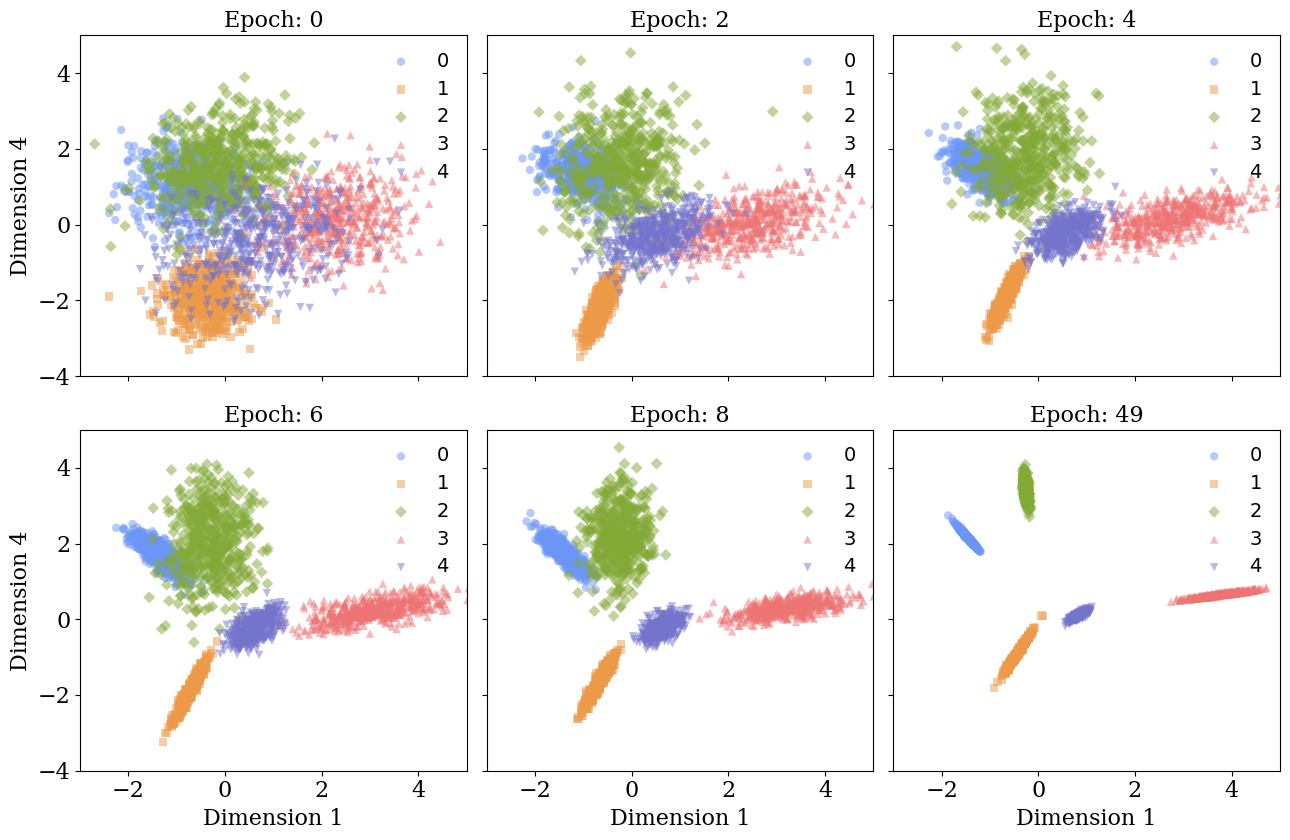

In [5]:
import matplotlib.pyplot as plt
import os
from torch.distributions import MultivariateNormal
import torch
import numpy as np
# 启用 LaTeX 风格文本渲染
import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['axes.titlesize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['legend.fontsize'] = 14
# 全局字体设置（适合论文展示）


# 数据准备
prior_list = [flattened_dict[key]['prior'] for key in flattened_dict.keys()]
cluster_idx = np.argsort(list(tool.cal_acc(pred_label, true_label.reshape(-1).cpu().numpy())[1][1]))
idx_c = [1, 4]

selected_indices = np.linspace(0, len(prior_list)-1, 25, dtype=int)
selected_indices = list(selected_indices[:5]) + list(selected_indices[-1:])
selected_priors = [prior_list[i] for i in selected_indices]
selected_keys = np.array(list(flattened_dict.keys()))[selected_indices]

# 统一坐标轴范围（可根据需要关闭）
xlims, ylims = [-3, 5], [-4, 5]

# 创建子图
fig, axs = plt.subplots(2, 3, figsize=(13, 8.5), sharex=True, sharey=True)

for idx, (key, prior) in enumerate(zip(selected_keys, selected_priors)):
    mean = prior[0].cpu()
    covariance = prior[1].cpu()
    ax = axs[idx // 3, idx % 3]

    for i in range(len(mean)):
        mvn = MultivariateNormal(torch.tensor(mean[cluster_idx[i]]), torch.tensor(covariance[cluster_idx[i]]))
        samples = mvn.sample((500,))
        ax.scatter(samples[:, idx_c[0]], samples[:, idx_c[1]], alpha=0.5,
                   label=f"${i}$", marker=markers[i], color=colors[i], edgecolors='none')

    ax.set_title(f"Epoch: {key[0]}")
    ax.set_xlabel(f"Dimension {idx_c[0]}")
    ax.set_ylabel(f"Dimension {idx_c[1]}")
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.label_outer()  # 仅显示边缘刻度
    ax.legend(loc='upper right', frameon=False)

# 调整布局
plt.tight_layout()

# 保存图像
name_ls = [str(dim), str(ratio), 'prior', '.pdf']
figpath = os.path.join('FIGs', '_'.join(name_ls))
# 保存为 PDF，高分辨率，适合论文插图
plt.savefig(figpath, dpi=300, bbox_inches='tight', format='pdf')
# plt.show()


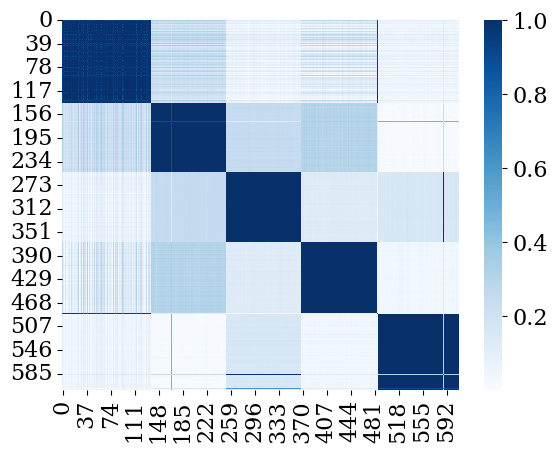

In [6]:
obj_vec = res['z']#res_dim['output']['z']
label = torch.argmax(res['prob_oo'], dim=1).detach().cpu().numpy()
obj = (obj_vec/torch.norm(obj_vec, dim=1).reshape(-1,1))[label.argsort()]
or_res = (obj @ obj.T).cpu().detach().numpy()
plt.figure()
sns.heatmap(abs(or_res[::10,::10]), cmap='Blues')
#plt.title(f"Epoch: {best_epoch}, Batch: {n_batch}")

name_ls = [str(dim), str(ratio), 'heat','.png']
figpath = os.path.join('FIGs', '_'.join(name_ls))
plt.savefig(figpath, dpi=300)

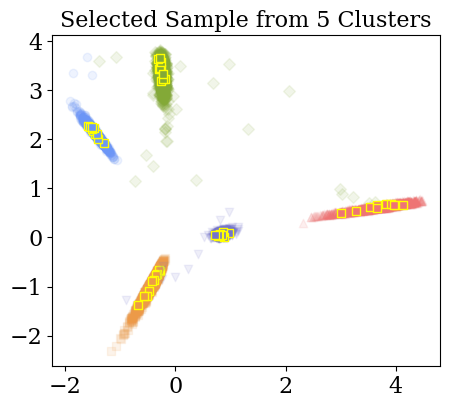

In [7]:
# 不同类别sample样本，绘制原始图像：
z = res['z'].cpu().numpy()
plt.figure(figsize=(5, 4.3))
idx_c_ls = []
idx_p = [1, 4]
for i in range(latent_dim):
    idx = np.where(pred_label == cluster_idx[i])[0]
    sample_idx = idx  # 取第一个样本
    sample_data = z[sample_idx,:]
    plt.scatter(sample_data[:,idx_p[0]], sample_data[:,idx_p[1]], alpha = 0.11, marker=markers[i], color=colors[i])
    
    # sort 第一个主成分方向， 沿着第一个主成分的方向等距采样得到样本idx，绘制原始sns
    selected_indices = np.linspace(90, sample_data.shape[0]-80, 10, dtype=int)
    idx_cc = np.argsort(sample_data[:,3])[selected_indices]
    idx_c = idx[idx_cc]
    idx_c_ls.append(idx_c) 
    
    plt.scatter(sample_data[idx_cc,idx_p[0]], sample_data[idx_cc,idx_p[1]], alpha = 1, marker='s', color=colors[i], edgecolors='yellow', linewidths =1)
plt.title(f"Selected Sample from {5} Clusters")

name_ls = [str(dim), str(ratio), 'samples','.pdf']
figpath = os.path.join('FIGs', '_'.join(name_ls))
plt.savefig(figpath)

    #plt.axis('off')
    #plt.show()

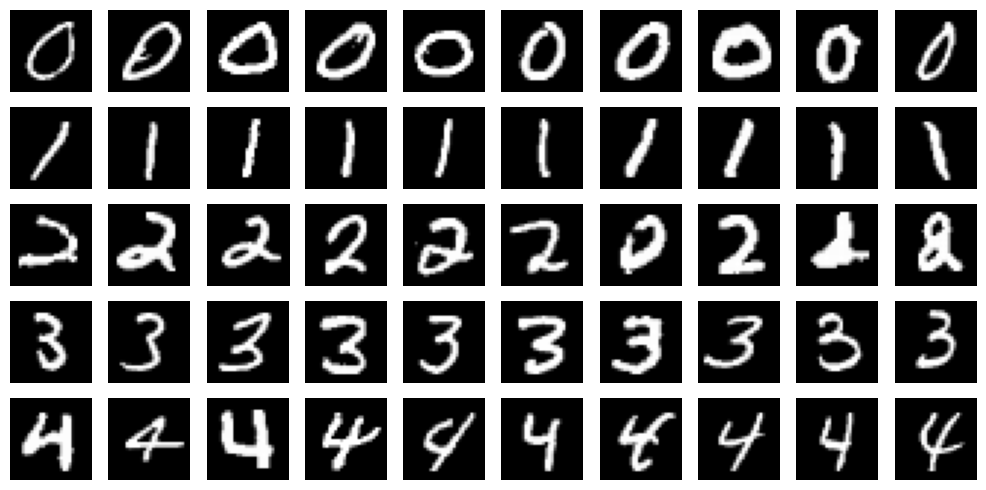

In [8]:
plt.figure(figsize=(10, 5))
m = 0
for idx_c in idx_c_ls:
    for idxs in idx_c:
        m+=1
        sensor_data = t_model_sensor_data[idxs,:]
        plt.subplot(latent_dim, 10, m)
        plt.imshow(sensor_data.cpu().numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        

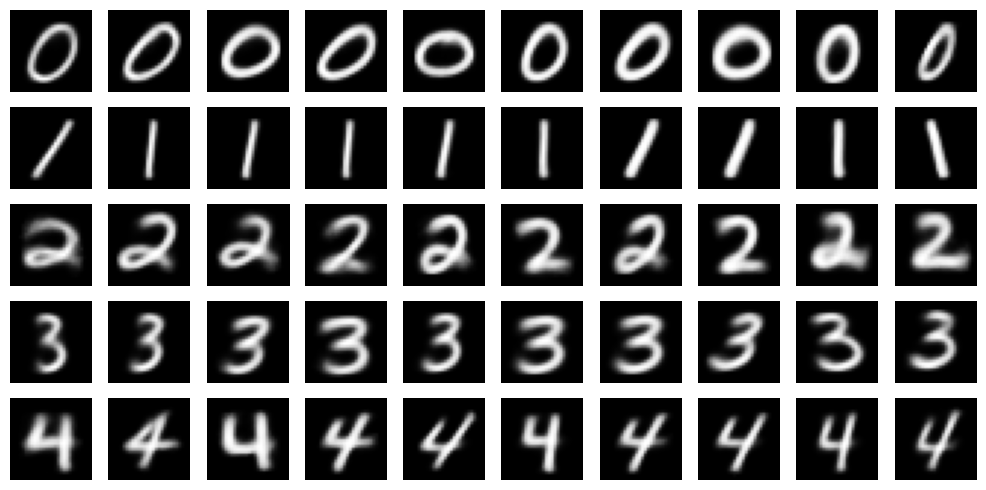

In [9]:
plt.figure(figsize=(10, 5))
m = 0
for idx_c in idx_c_ls:
    for idxs in idx_c:
        m+=1
        sensor_data = res['recons'][idxs,:]
        plt.subplot(latent_dim, 10, m)
        plt.imshow(sensor_data.cpu().numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        